In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cobra.io import read_sbml_model
from cobra import Model

In [2]:
def combine_models(model_1, model_2):
    for met in model_1.metabolites:
        met.id += '__Strain1'

    for met in model_2.metabolites:
        met.id += '__Strain2'

    for rxn in model_1.reactions:
        rxn.id += '__Strain1'
    for rxn in model_2.reactions:
        rxn.id += '__Strain2'

    model_1_rxns = [rxn.copy() for rxn in model_1.reactions]
    model_2_rxns = [rxn.copy() for rxn in model_2.reactions]

    new_model = Model(id_or_model='benzoic acid dependent co-culture')

    new_model.add_reactions(model_1_rxns)
    new_model.add_reactions(model_2_rxns)
    
    return new_model

In [3]:
def calculate_agg_flux(model, rxn_inter, rxn_prod, num_step=200):
    ns = np.linspace(0, 1, num_step+1)[1:]

    f_aggs = []

    for n in ns:
        with model as m:
            m.reactions.ATPM__Strain1.lower_bound = 0
            m.reactions.ATPM__Strain2.lower_bound = 0
            const_inter = m.problem.Constraint(
                m.reactions.get_by_id(rxn_inter+'__Strain1').flux_expression
                + n * m.reactions.get_by_id(rxn_inter+'__Strain2').flux_expression,
                lb = 0
            )
            m.add_cons_vars(const_inter)
            m.objective = rxn_prod + '__Strain2'
            f = m.slim_optimize()
            f_aggs.append(n/(n+1)*f)
            
    return ns, np.array(f_aggs)

In [4]:
def draw_response(f_aggs, fig_dir=None):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(ns, f_aggs, 'k-', )
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Biomass ratio (Strain 2/Strain 1)')
    ax.set_ylabel('Benzyl acetate production flux [mmol/gDCW/h]')
    ax.set_xlim(left=0, right=1.0)
    if fig_dir != None:
        plt.savefig(fig_dir, dpi=300)
    plt.show()
    plt.close()
    return

In [5]:
output_dir = './analysis_output'

if output_dir[-1] == '/':
    output_dir = output_dir[:-1]

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Co-culture (benzoic acid dependent pathway)

In [6]:
fig_dir = f'{output_dir}/bz_dp_combined.svg'
txt_dir = f'{output_dir}/bz_dp_combined.txt'

model_dir_1 = './model_files/iML1515_bz_dp_co_1.xml'
model_dir_2 = './model_files/iML1515_bz_dp_co_2.xml'

rxn_inter = 'EX_bz_e'
rxn_prod = 'EX_bzac_e'

In [7]:
model_1 = read_sbml_model(model_dir_1)
model_2 = read_sbml_model(model_dir_2)
model_bz_dp = combine_models(model_1, model_2)

Academic license - for non-commercial use only - expires 2024-06-11
Using license file /data/user_home/gbkim/gurobi.lic


In [8]:
ns, f_aggs_bz_dp = calculate_agg_flux(model_bz_dp, rxn_inter, rxn_prod)

In [9]:
df = pd.DataFrame([ns, f_aggs_bz_dp]).T
df.columns = ['Biomass ratio (Strain2/Strain1)', 'Benzyl acetate production flux [mmol/gDCW/h]']
df.to_csv(txt_dir, sep='\t')
display(df)

,Biomass ratio (Strain2/Strain1),Benzyl acetate production flux [mmol/gDCW/h]
0,0.005,0.088084
1,0.010,0.175296
2,0.015,0.261649
3,0.020,0.347155
4,0.025,0.431827
...,...,...
195,0.980,3.309650
196,0.985,3.301313
197,0.990,3.293018
198,0.995,3.284765


In [10]:
max_idx = f_aggs_bz_dp.argmax()
ratio_max = ns[max_idx]
flux_max = f_aggs_bz_dp[max_idx]
print(f'Maximum flux at the biomass ratio of {ratio_max}: {flux_max: 0.4f} mmol/gDCW/h')

Maximum flux at the biomass ratio of 0.37:  4.7816 mmol/gDCW/h


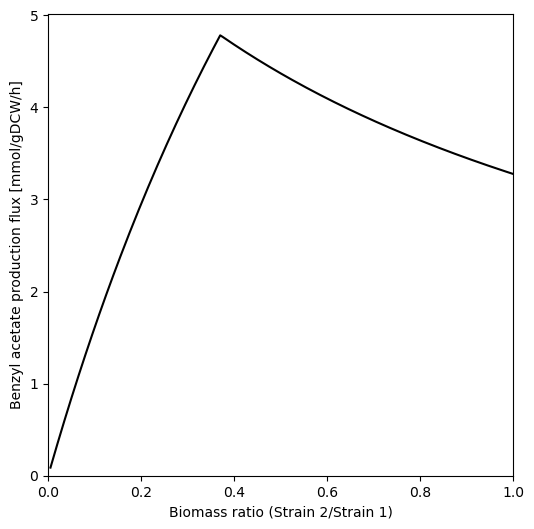

In [11]:
draw_response(f_aggs_bz_dp, fig_dir=fig_dir)

### Co-culture (benzoic acid independent pathway)

In [12]:
fig_dir = f'{output_dir}/bz_idp_combined.svg'
txt_dir = f'{output_dir}/bz_idp_combined.txt'

model_dir_1 = './model_files/iML1515_bz_idp_co_1.xml'
model_dir_2 = './model_files/iML1515_bz_idp_co_2.xml'

rxn_inter = 'EX_bzalc_e'
rxn_prod = 'EX_bzac_e'

In [13]:
model_1 = read_sbml_model(model_dir_1)
model_2 = read_sbml_model(model_dir_2)
model_bz_idp = combine_models(model_1, model_2)

In [14]:
ns, f_aggs_bz_idp = calculate_agg_flux(model_bz_idp, rxn_inter, rxn_prod)

In [15]:
df = pd.DataFrame([ns, f_aggs_bz_idp]).T
df.columns = ['Biomass ratio (Strain2/Strain1)', 'Benzyl acetate production flux [mmol/gDCW/h]']
df.to_csv(txt_dir, sep='\t')
display(df)

,Biomass ratio (Strain2/Strain1),Benzyl acetate production flux [mmol/gDCW/h]
0,0.005,0.135138
1,0.010,0.268939
2,0.015,0.401421
3,0.020,0.532604
4,0.025,0.662507
...,...,...
195,0.980,2.556753
196,0.985,2.550312
197,0.990,2.543905
198,0.995,2.537529


In [16]:
max_idx = f_aggs_bz_idp.argmax()
ratio_max = ns[max_idx]
flux_max = f_aggs_bz_idp[max_idx]
print(f'Maximum flux at the biomass ratio of {ratio_max}: {flux_max: 0.4f} mmol/gDCW/h')

Maximum flux at the biomass ratio of 0.19:  4.2541 mmol/gDCW/h


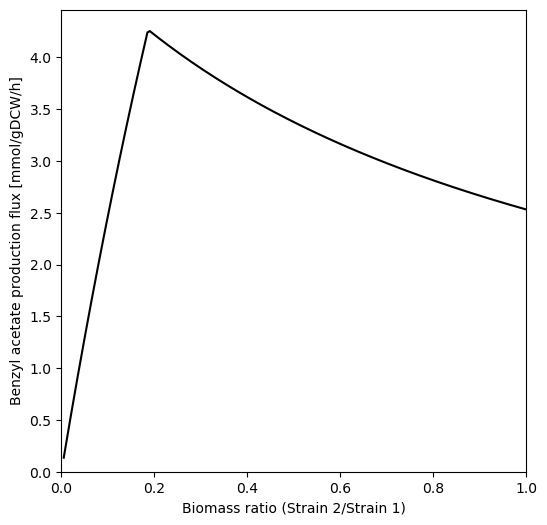

In [17]:
draw_response(f_aggs_bz_idp, fig_dir=fig_dir)